# <center style='color:forestgreen'>Train a `CNN` without `data augmentation` - Example using `Flowers102` dataset</center>

# 1. Import required libraries

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, ConcatDataset
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np

# 2. Define the device

In [2]:
print('PyTorch version:', torch.__version__, '\n')
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device is:', device, '\n')
print('Total number of GPUs:', torch.cuda.device_count())

PyTorch version: 2.0.1+cu117 

GPU name: NVIDIA RTX A5000 

Device is: cuda 

Total number of GPUs: 1


# 3. Apply transformation `without data augmentation`

In [3]:
transform = transforms.Compose([transforms.Resize((500, 500)), transforms.ToTensor()])

# 4. Load `Flowers102` dataset

In [4]:
training_dataset = datasets.Flowers102(root='data_src', split='train', download=True, transform=transform)
validation_dataset = datasets.Flowers102(root='data_src', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='data_src', split='test', download=True, transform=transform)

In [5]:
print('Length of the training dataset:', len(training_dataset))
print('Length of the validation dataset:', len(validation_dataset))
print('Length of the test dataset:', len(test_dataset))

Length of the training dataset: 1020
Length of the validation dataset: 1020
Length of the test dataset: 6149


In [6]:
train_set = test_dataset
test_set = ConcatDataset([training_dataset, validation_dataset])

In [7]:
print('Length of the train_set:', len(train_set))
print('Length of the test_set:', len(test_set))

Length of the train_set: 6149
Length of the test_set: 2040


In [8]:
txt_file = open('flowers102_label_names.txt', 'r').read().splitlines()
class_names = [x.replace('"', '').replace("'", '') for x in txt_file]

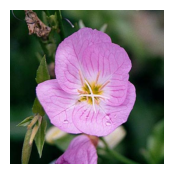

In [9]:
plt.figure(figsize=(2, 2))
plt.imshow(train_set[0][0].permute(1, 2, 0))
plt.axis(False);

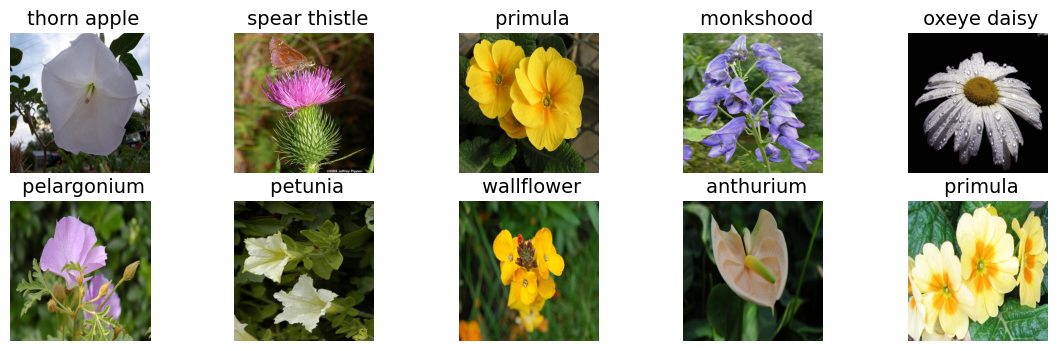

In [10]:
fig, axis = plt.subplots(nrows=2, ncols=5, figsize=(14, 4))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(train_set))
    ax.imshow(train_set[inx][0].permute(1, 2, 0))
    ax.set_title(class_names[train_set[inx][1]], fontsize=14)
    ax.axis(False);

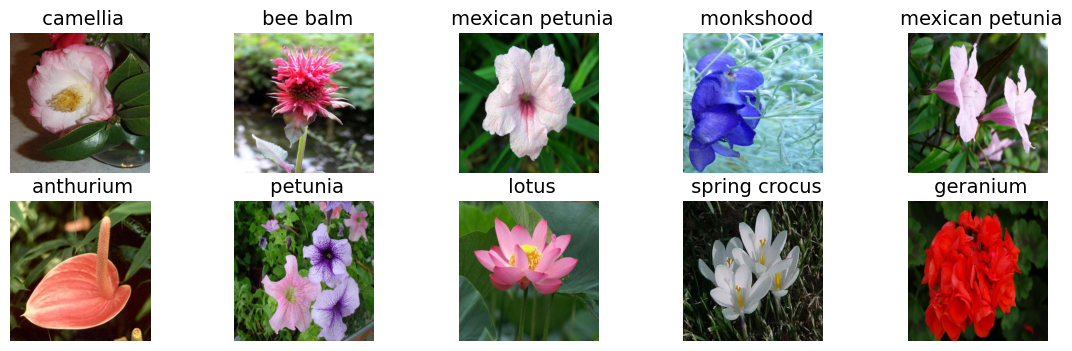

In [11]:
fig, axis = plt.subplots(nrows=2, ncols=5, figsize=(14, 4))

for ax, _ in zip(axis.ravel(), range(10)):
    inx = np.random.randint(len(test_set))
    ax.imshow(test_set[inx][0].permute(1, 2, 0))
    ax.set_title(class_names[test_set[inx][1]], fontsize=14)
    ax.axis(False);

# 5. Define dataloaders

In [12]:
train_dataloader = DataLoader(train_set, batch_size=30, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_set, batch_size=30, shuffle=False)

In [13]:
print('Length of the train dataloader:', len(train_dataloader))
print('Length of the test dataloader:', len(test_dataloader))

Length of the train dataloader: 204
Length of the test dataloader: 68


# 6. Create `CNN` architecture

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.fe = nn.Sequential()
        self.fe.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding=1))
        self.fe.add_module('bnor1', nn.BatchNorm2d(num_features=16))
        self.fe.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        self.fe.add_module('relu1', nn.ReLU(inplace=True))
        self.fe.add_module('conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1))
        self.fe.add_module('bnor2', nn.BatchNorm2d(num_features=32))
        self.fe.add_module('pool2', nn.MaxPool2d(kernel_size=3, stride=2))
        self.fe.add_module('relu2', nn.ReLU(inplace=True))
        self.fe.add_module('conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2))
        self.fe.add_module('bnor3', nn.BatchNorm2d(num_features=64))
        self.fe.add_module('pool3', nn.MaxPool2d(kernel_size=2, stride=2))
        self.fe.add_module('relu3', nn.ReLU(inplace=True))
        self.fe.add_module('flat3', nn.Flatten())
        
        self.cl = nn.Sequential()
        self.cl.add_module('linr1', nn.Linear(in_features=3136, out_features=1024))
        self.cl.add_module('drop1', nn.Dropout(p=0.5))
        self.cl.add_module('relu1', nn.ReLU(inplace=True))
        self.cl.add_module('linr2', nn.Linear(in_features=1024, out_features=512))
        self.cl.add_module('drop2', nn.Dropout(p=0.5))
        self.cl.add_module('relu2', nn.ReLU(inplace=True))
        self.cl.add_module('linr3', nn.Linear(in_features=512, out_features=102))
        
    def forward(self, x):
        x = self.fe(x)
        x = self.cl(x)
        return x

# 7. Visualize `CNN` architecture

In [15]:
summary(CNN(), input_size=(30, 3, 500, 500))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [30, 102]                 --
├─Sequential: 1-1                        [30, 3136]                --
│    └─Conv2d: 2-1                       [30, 16, 250, 250]        784
│    └─BatchNorm2d: 2-2                  [30, 16, 250, 250]        32
│    └─MaxPool2d: 2-3                    [30, 16, 125, 125]        --
│    └─ReLU: 2-4                         [30, 16, 125, 125]        --
│    └─Conv2d: 2-5                       [30, 32, 63, 63]          4,640
│    └─BatchNorm2d: 2-6                  [30, 32, 63, 63]          64
│    └─MaxPool2d: 2-7                    [30, 32, 31, 31]          --
│    └─ReLU: 2-8                         [30, 32, 31, 31]          --
│    └─Conv2d: 2-9                       [30, 64, 15, 15]          18,496
│    └─BatchNorm2d: 2-10                 [30, 64, 15, 15]          128
│    └─MaxPool2d: 2-11                   [30, 64, 7, 7]            --
│    └

# 8. Define the train batch

In [16]:
def train_batch(data, labels, model, criterion, optimizer):
    model.train()
    data = data.to(device)
    labels = labels.to(device)
    output = model(data)
    loss = criterion(output, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

# 9. Define the test batch

In [17]:
with torch.inference_mode():
    def test_batch(data, labels, model, criterion):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        loss = criterion(output, labels)
        return loss

# 10. Define the accuracy function

In [18]:
with torch.inference_mode():
    def accuracy(data, labels, model):
        model.eval()
        data = data.to(device)
        labels = labels.to(device)
        output = model(data)
        _, pred_labels = output.max(-1)
        correct = (pred_labels == labels)
        return correct.cpu().detach().numpy().tolist()

# 11. Set up model (`CNN`), criterion (`loss function`) and optimizer

In [19]:
cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

# 12. Train `CNN`

In [20]:
np.random.seed(42)
torch.manual_seed(42)
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

n_epochs = 50

train_loss, test_loss = [], []
train_accuracy, test_accuracy = [], []

for epoch in range(n_epochs):
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []
    
    for data, labels in train_dataloader:
        trng_batch_loss = train_batch(data, labels, cnn, criterion, optimizer)
        train_losses.append(trng_batch_loss.item())
        trng_batch_correct = accuracy(data, labels, cnn)
        train_accuracies.extend(trng_batch_correct)
    train_per_epoch_loss = np.array(train_losses).mean()
    train_per_epoch_accuracy = np.mean(train_accuracies)
    
    for data, labels in test_dataloader:
        tst_batch_loss = test_batch(data, labels, cnn, criterion)
        test_losses.append(tst_batch_loss.item())
        tst_batch_correct = accuracy(data, labels, cnn)
        test_accuracies.extend(tst_batch_correct)
    test_per_epoch_loss = np.array(test_losses).mean()
    test_per_epoch_accuracy = np.mean(test_accuracies)
    
    train_loss.append(train_per_epoch_loss)
    train_accuracy.append(train_per_epoch_accuracy)
    test_loss.append(test_per_epoch_loss)
    test_accuracy.append(test_per_epoch_accuracy)
    
    if (epoch+1) % 10==0:
        print(f'Epoch: {epoch+1}/{n_epochs} | Train loss: {train_per_epoch_loss:.4f} | ', end='')
        print(f'Train accuracy: {train_per_epoch_accuracy:.4f} | Test loss: {test_per_epoch_loss:.4f} | ', end='')
        print(f'Test accuracy: {test_per_epoch_accuracy:.4f}')

Epoch: 10/50 | Train loss: 2.1479 | Train accuracy: 0.5605 | Test loss: 2.4560 | Test accuracy: 0.3598
Epoch: 20/50 | Train loss: 1.3719 | Train accuracy: 0.8105 | Test loss: 1.9203 | Test accuracy: 0.4995
Epoch: 30/50 | Train loss: 0.8784 | Train accuracy: 0.9374 | Test loss: 1.9438 | Test accuracy: 0.5221
Epoch: 40/50 | Train loss: 0.6584 | Train accuracy: 0.9796 | Test loss: 1.9522 | Test accuracy: 0.5475
Epoch: 50/50 | Train loss: 0.4850 | Train accuracy: 0.9961 | Test loss: 2.1410 | Test accuracy: 0.5216


# 13. Plot model loss and accuracy

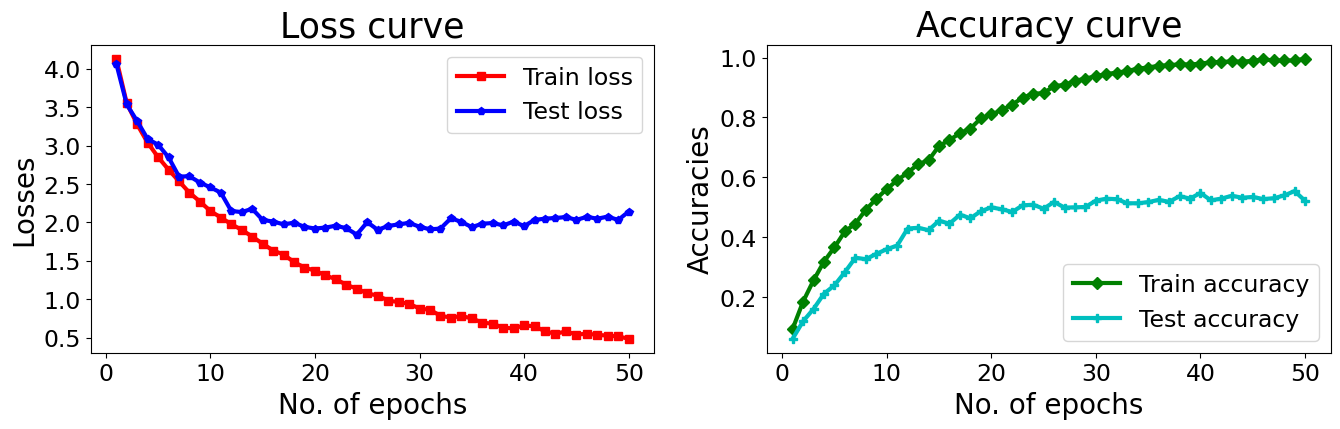

In [21]:
N = np.arange(50) + 1

fig = plt.figure(figsize=(16, 4))

fig.add_subplot(1, 2, 1)
plt.plot(N, train_loss, 'r-s', linewidth=3, label='Train loss')
plt.plot(N, test_loss, 'b-p', linewidth=3, label='Test loss')
plt.title('Loss curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Losses', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17)

fig.add_subplot(1, 2, 2)
plt.plot(N, train_accuracy, 'g-D', linewidth=3, label='Train accuracy')
plt.plot(N, test_accuracy, 'c-P', linewidth=3, label='Test accuracy')
plt.title('Accuracy curve', fontsize=25)
plt.xlabel('No. of epochs', fontsize=20)
plt.ylabel('Accuracies', fontsize=20)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
plt.legend(fontsize=17);

# 14. Model prediction

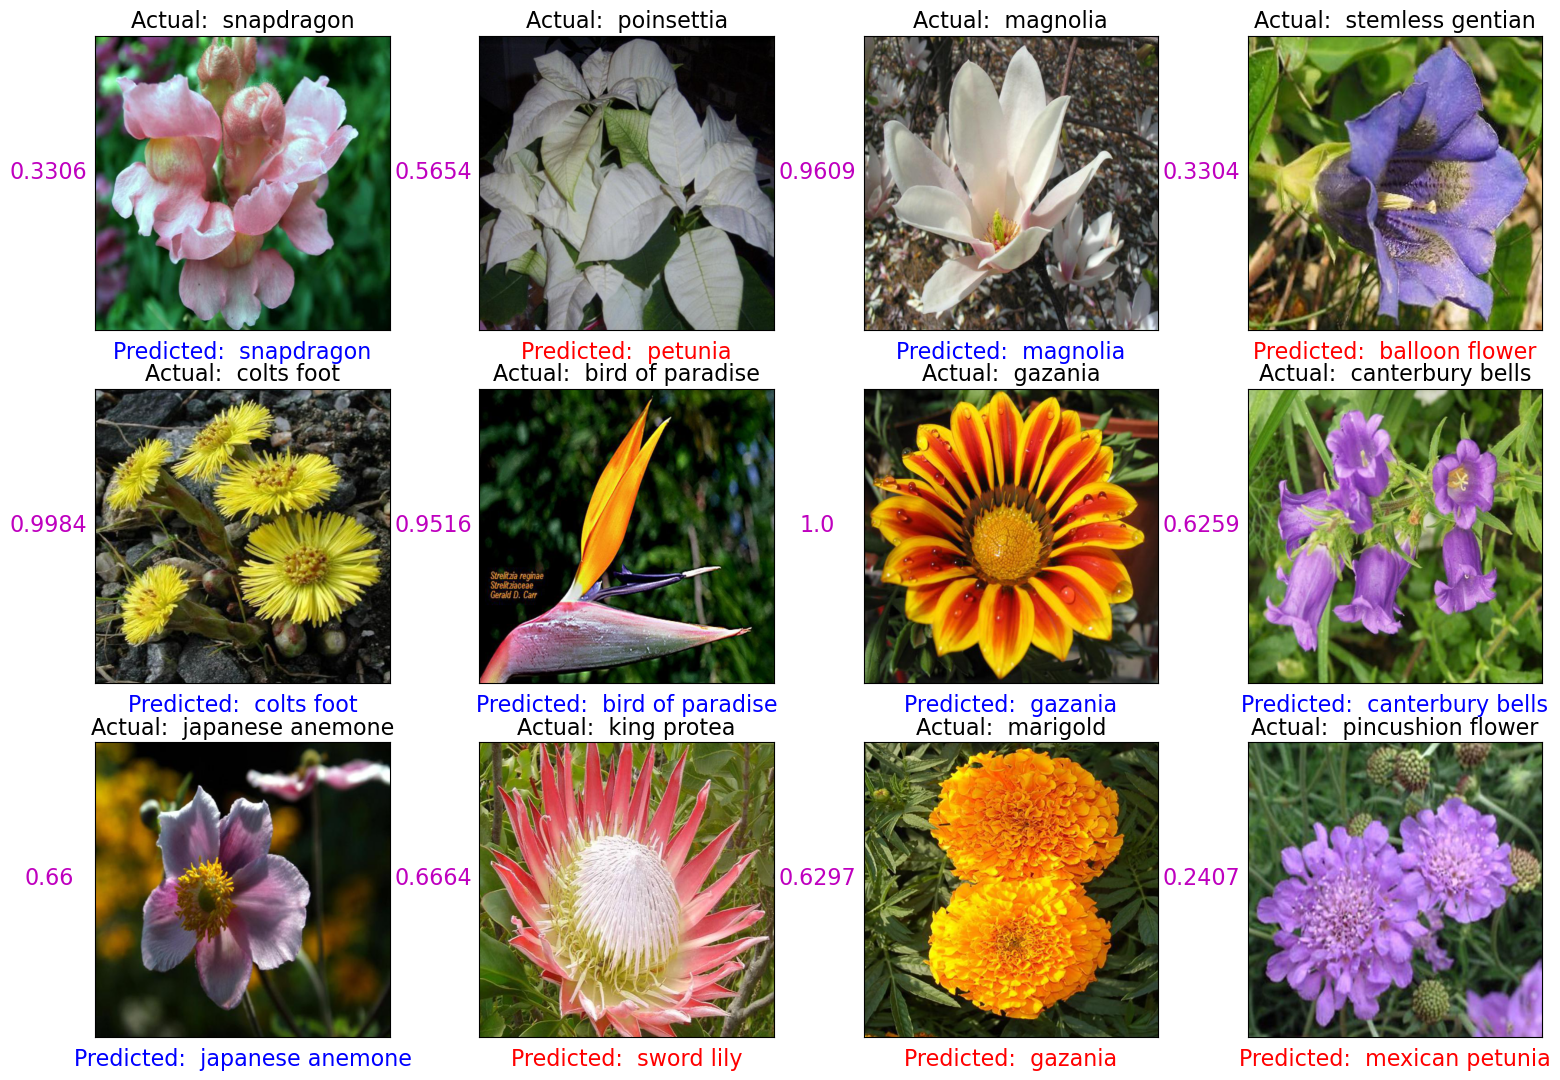

In [22]:
SAMPLES, PREDS, LABELS = [], [], []

for a in range(12):
    idx = np.random.randint(len(test_set))
    SAMPLES.append(test_set[idx])
    output = F.softmax(cnn.cpu()(SAMPLES[a][0].unsqueeze(0)), dim=-1)
    pred_values, pred_labels = output.max(-1)
    PREDS.append(round(float(pred_values), 4))
    LABELS.append(int(pred_labels))

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(19, 13))
i = 0
for R in range(3):
    for C in range(4):
        ax[R, C].imshow(SAMPLES[i][0].permute(1, 2, 0))
        ax[R, C].set_title('Actual: ' + class_names[SAMPLES[i][1]], fontsize=16).set_color('k')
        if SAMPLES[i][1] == LABELS[i]:
            ax[R, C].set_xlabel('Predicted: ' + class_names[LABELS[i]], fontsize=16).set_color('b')
        else:
            ax[R, C].set_xlabel('Predicted: ' + class_names[LABELS[i]], fontsize=16).set_color('r')
        ax[R, C].set_ylabel(PREDS[i], fontsize=16, rotation=0, labelpad=30).set_color('m')
        ax[R, C].set_xticks([])
        ax[R, C].set_yticks([])
        i += 1